<a href="https://colab.research.google.com/github/Praveen76/Finetune-Llama2-on-Custom-Data/blob/main/Fine_tune_Llama2_on_custom_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# !pip install tensorflow==2.8.1
!pip install --upgrade tensorflow



In [21]:
!pip install kaggle
!pip install xlsxwriter

!pip install transformers
!pip install datasets
!pip install transformers[sentencepiece] datasets
!pip install sentencepiece
!pip install openai cohere tiktoken rouge nltk rouge-score peft trl bitsandbytes accelerate

In [22]:
import tensorflow as tf

# Print the TensorFlow version
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


In [23]:
#Basic Libraries
import os
import numpy as np
import pandas as pd
#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
#Text Handling Libraries
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import xlsxwriter
import scipy.spatial
import datetime

from datasets import load_dataset
from transformers import pipeline



In [24]:
import yaml
import json

from google.colab import drive

# Mount Google Drive with force remount
drive.mount('/content/drive', force_remount=True)


# Load relevant API Keys
file_path = '/content/drive/MyDrive/.API_KEYS/API_KEYS.yml'

with open(file_path, 'r') as file:
    api_keys = yaml.safe_load(file)


# Extract Kaggle username and key
HF_READ_API_KEY = api_keys['HUGGINGFACE']['HF_READ_API_KEY']
HF_WRITE_API_KEY = api_keys['HUGGINGFACE']['HF_WRITE_API_KEY']

# Save the token using HfFolder
from huggingface_hub.hf_api import HfFolder
HfFolder.save_token(HF_READ_API_KEY)


Mounted at /content/drive


In [25]:
!git clone https://github.com/Praveen76/Conversation-AI-System-using-LLMs-on-E-commerce-Data.git
%cd Conversation-AI-System-using-LLMs-on-E-commerce-Data

Cloning into 'Conversation-AI-System-using-LLMs-on-E-commerce-Data'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 89 (delta 50), reused 5 (delta 0), pack-reused 0
Receiving objects: 100% (89/89), 11.30 MiB | 19.16 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Conversation-AI-System-using-LLMs-on-E-commerce-Data/Conversation-AI-System-using-LLMs-on-E-commerce-Data


In [26]:
# Load Data
df = pd.read_csv("./OSS_LLMs_Data.csv")

In [27]:
df.columns

Index(['Unnamed: 0', 'product_id', 'ProdName', 'category', 'DPrice', 'APrice',
       'DPerct', 'rating', 'ProdDescr', 'UID', 'UName', 'review_id',
       'review_title', 'review_content', 'img_link', 'ProdLink', 'Subcategory',
       'rBucket', 'DPBucket', 'product_classification_features', 'score',
       'Ques', 'Anws', 'GPTSumm', 'Sentiment'],
      dtype='object')

In [28]:
cols = ['ProdDescr','GPTSumm']
df = df[cols]

In [29]:
from sklearn.model_selection import train_test_split

# 9:1 for train and rest
train_data, test_data = train_test_split(df, test_size=0.1, random_state=123456)

print(len(train_data), "train +", len(test_data), "test")

660 train + 74 test


In [30]:
import json
import pandas as pd

train_data_dict = train_data.to_dict(orient='records')
test_data_dict = test_data.to_dict(orient='records')

with open('./train.json', 'w', encoding='utf-8') as f:
    json.dump(train_data_dict, f, ensure_ascii=False, indent=4)

with open('./test.json', 'w', encoding='utf-8') as f:
    json.dump(test_data_dict, f, ensure_ascii=False, indent=4)

In [31]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='./train.json', split='train')
eval_dataset = load_dataset('json', data_files='./test.json', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [32]:
train_dataset,eval_dataset

(Dataset({
     features: ['GPTSumm', 'ProdDescr'],
     num_rows: 660
 }),
 Dataset({
     features: ['GPTSumm', 'ProdDescr'],
     num_rows: 74
 }))

In [40]:
def formatting_func(example):
    text = f'''### Instruction:

      You are an autonomous agent on an E-commerce website, and this is a product summarization task. You need to summarize the product descriptions to customers.


      ### Product Description:
      {example['ProdDescr']}


      ### Summary:
      {example['GPTSumm']}

      '''

    return text

In [34]:
from random import randrange

print(formatting_func(train_dataset[randrange(len(train_dataset))]))

### Instruction:

      You are an autonomous agent on an E-commerce website, and t his is a product summarization task.  You need to summarize the product descriptions to customers.


      ### Product Description:
      3 Boiling Modes - The advanced appliance from Milton, by Hydro Valves allows you to boil eggs in 3 different modes - Hard, Medium and Soft.|Automatic Shut Off - The machine will turn off automatically when the eggs are boiled|Before switching on the appliance, make sure that your home's main voltage corresponds to the operating unit.|Customer Support Information - Milton Egg Boilers Customer Support Number : +91 93556 45866 (Available Monday to Saturday from 10:00 AM to 6:00 PM except national holidays)


      ### Summary:
      The Milton Egg Boilers have 3 boiling modes and an automatic shut off feature. Before use, make sure your home's voltage is compatible. For customer support, call +91 93556 45866 Monday-Saturday from 10:00 AM to 6:00 PM.

      


In [35]:
from huggingface_hub import login

# Replace <your_token> with your actual token
token = HF_READ_API_KEY

# Login with your token
login(token=token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [36]:
import os
import torch
# from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [37]:
# Model from Hugging Face hub
base_model = "NousResearch/Llama-2-7b-chat-hf"

# New instruction dataset
# guanaco_dataset = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model
# new_model = "llama-2-7b-chat-guanaco"

compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)



In [38]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [39]:
import torch
from transformers import LlamaForCausalLM, LlamaTokenizer
from datasets import config

# config.HF_DATASETS_CACHE = '/data/yuhong_zhao/cache/datasets'

model_id=base_model

tokenizer = LlamaTokenizer.from_pretrained(
    model_id,
    # padding_side="left",
    # add_eos_token=True,
    # add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

model =LlamaForCausalLM.from_pretrained(model_id, load_in_8bit=True, device_map='auto', torch_dtype=torch.float16,
                                        cache_dir='/data/Praveen/cache/transformers'
                                        )

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

In [43]:
#### Check Base Model
from random import randrange

eval_prompt = formatting_func(train_dataset[randrange(len(train_dataset))])


model_input = tokenizer(eval_prompt, return_tensors="pt", truncation=True).to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))

### Instruction:

      You are an autonomous agent on an E-commerce website, and this is a product summarization task.  You need to summarize the product descriptions to customers.


      ### Product Description:
      COLORFUL LIGHTSYNC RGB : Play in colour with our most vibrant LIGHTSYNC RGB featuring colour wave effects that are customisable across 16.8 million colours. 8,000 DPI sensor.|CLASSIC,GAMER TESTED DESIGN : Play comfortably and with total control. The simple 6-button layout and classic gaming shape form a comfortable, time-tested and loved design|MECHANICAL SPRING BUTTON TENSIONING: Primary buttons are mechanical and tensioned with durable metal springs for reliability, performance and an excellent feel|CUSTOMIZABLE SETTINGS : To suit the sensitivity you like with Logitech G HUB gaming software and cycle easily through up to 5 DPI settings; SYSTEM REQUIREMENTS : Windows 7 or later, macOS 10.11 or later, Chrome OSTM, USB port, Internet access for Logitech Gaming Software 

In [44]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt), truncation=True)

In [45]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

In [46]:
tokenized_train_dataset

Dataset({
    features: ['GPTSumm', 'ProdDescr', 'input_ids', 'attention_mask'],
    num_rows: 660
})

In [47]:
tokenized_val_dataset

Dataset({
    features: ['GPTSumm', 'ProdDescr', 'input_ids', 'attention_mask'],
    num_rows: 74
})

734


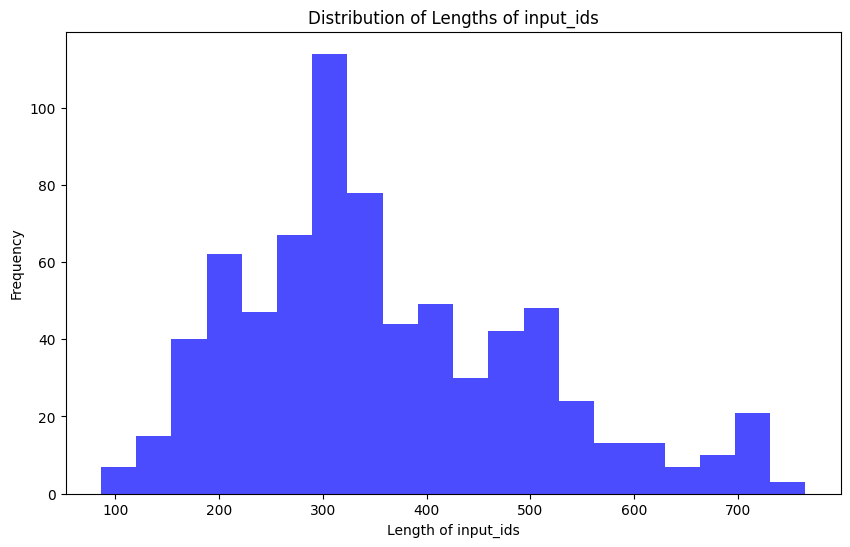

In [48]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [49]:
max_length = 1024 # Change as per your dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        # prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [50]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

In [51]:
tokenized_train_dataset

Dataset({
    features: ['GPTSumm', 'ProdDescr', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 660
})

In [52]:
tokenized_val_dataset

Dataset({
    features: ['GPTSumm', 'ProdDescr', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 74
})

In [53]:
print(tokenized_train_dataset[1]['input_ids'])

[1, 835, 2799, 4080, 29901, 13, 13, 418, 887, 526, 385, 28273, 681, 10823, 373, 385, 382, 29899, 22529, 4700, 29892, 322, 445, 338, 263, 3234, 19138, 2133, 3414, 29889, 29871, 887, 817, 304, 19138, 675, 278, 3234, 2342, 1980, 304, 20330, 29889, 13, 13, 13, 418, 835, 10969, 12953, 29901, 13, 418, 399, 2749, 424, 29891, 29901, 29871, 29906, 1629, 1370, 21867, 29891, 4944, 491, 278, 12012, 9945, 515, 2635, 310, 20590, 29989, 797, 27722, 29901, 29871, 29896, 5190, 16843, 29892, 29871, 29896, 399, 300, 1632, 4995, 14631, 29892, 29871, 29896, 678, 329, 3801, 14631, 29892, 29871, 29896, 360, 719, 1632, 4995, 14631, 29989, 29924, 520, 13988, 29871, 29929, 281, 1131, 29879, 10992, 411, 3765, 8287, 11460, 886, 363, 19201, 29892, 4482, 25413, 322, 7458, 3889, 2734, 363, 2440, 29989, 29928, 608, 14631, 363, 7990, 867, 4015, 29892, 29871, 29906, 5004, 380, 475, 2222, 22973, 432, 1503, 363, 15589, 867, 4015, 322, 521, 329, 3801, 867, 4015, 29989, 29906, 29906, 364, 3358, 5858, 29899, 11551, 29879, 2

734


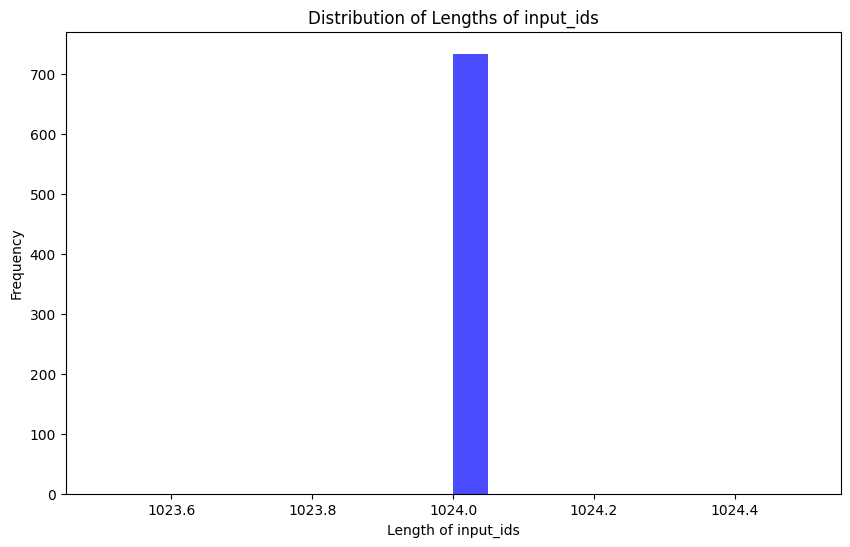

In [54]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [55]:
################### Setup LoRA

from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [56]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [57]:
from peft import LoraConfig, get_peft_model
from accelerate import Accelerator
accelerator = Accelerator()

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator.
model = accelerator.prepare_model(model)

trainable params: 81108992 || all params: 6819524608 || trainable%: 1.1893643129442022


In [58]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear8bitLt(
                (bas

In [59]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

# num_epochs = 1  # Set the desired number of epochs
# max_steps = (len(tokenized_train_dataset) // per_device_train_batch_size) * num_epochs

max_steps= 50

project = "summary-evaluate-finetune"
base_model_name = "llama2-7b"
run_name = base_model_name + "-" + project
output_dir = "./tmp/llama-output/" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=max_steps,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir=f"{output_dir}/logs",
        logging_strategy="steps",
        logging_steps=50,
        save_strategy="no",       # Save the model checkpoint every logging step
        # save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="no",
        # eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,
        # report_to="wandb",
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings
trainer.train()

Step,Training Loss


In [47]:
model.save_pretrained(output_dir)

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:134: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [49]:
project = "summary-evaluate-finetune"
base_model_name = "llama2-7b"
run_name = base_model_name + "-" + project
output_dir = "./tmp/llama-output/" + run_name

model = LlamaForCausalLM.from_pretrained(output_dir, load_in_8bit=True, device_map='auto', torch_dtype=torch.float16,
                                         cache_dir='/data/Praveen76/cache/transformers'
                                         )

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

In [50]:
# model.eval()
# with torch.no_grad():
#     print(tokenizer.decode(model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))

### Instruction:

      You are an autonomous agent on an E-commerce website, and t his is a product summarization task.  You need to summarize the product descriptions to customers.


      ### Product Description:
      {example['ProdDescr']}


      ### Summary:
      {example['GPTSumm']}

      ### Attention:
      {example['Attn']}

      ### Length:
      {example['Leng']}

      ### Input:
      {example['Inp']}

      ### Output:
      {example['Out']}

      ### Evaluation Metrics:
      {example['EvalMet']}


      ### Note:
      This is a Python script, and you need to replace the
